In [1]:
#Running on real hardware

## Imports

In [2]:

import random
import ast

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

# Import libraries to be able to run on IBM quantum computers
from qiskit import Aer
from qiskit import *


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e5_patch
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data 

In [4]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
## malign and benign aee reverted !!!!!!!!!!!!!

diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

print('Malign: ', df['diagnosis'].value_counts()[0])
print('Benign: ', df['diagnosis'].value_counts()[1])

Malign:  305
Benign:  195


In [6]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


In [7]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0]
non_fraud_df = df.loc[df['diagnosis'] == 1][:195]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
264,889719,1.0,17.19,22.07,111.60,928.3,0.09726,0.08995,0.09061,0.06527,...,1436.0,0.1558,0.25670,0.38890,0.19840,0.3216,0.07570,NaN,0,30
170,87139402,0.0,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,...,549.1,0.1385,0.12660,0.12420,0.09391,0.2827,0.06771,NaN,0,30
85,8612399,1.0,18.46,18.52,121.10,1075.0,0.09874,0.10530,0.13350,0.08795,...,1603.0,0.1398,0.20890,0.31570,0.16420,0.3695,0.08579,NaN,0,30
268,8910506,0.0,12.87,16.21,82.38,512.2,0.09425,0.06219,0.03900,0.01615,...,597.5,0.1256,0.18080,0.19920,0.05780,0.3604,0.07062,NaN,0,30
275,8911164,0.0,11.89,17.36,76.20,435.6,0.12250,0.07210,0.05929,0.07404,...,472.4,0.1359,0.08368,0.07153,0.08946,0.2220,0.06033,NaN,2,28


In [8]:
sub_sample_corr = sub_sample_df.corr()

In [9]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [10]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    

In [11]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [12]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
413,0.449485,1.0,0.438694,0.142917,0.465039,0.241419,0.192644,0.273490
420,0.229003,1.0,0.344068,0.233794,0.362653,0.236605,0.070974,0.294780
206,0.192027,1.0,0.267038,0.312207,0.289123,0.279924,0.097018,0.274719
80,0.210550,1.0,0.336505,0.333119,0.363762,0.230019,0.110984,0.445036
289,0.213162,1.0,0.315645,0.210022,0.342952,0.432679,0.108002,0.404094


In [13]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
379,0.867354,0.766667,0.365287,0.237873,0.367370,0.220139,0.316451,0.210235
39,0.775945,1.000000,0.427150,0.172406,0.430910,0.174414,0.270328,0.121064
337,0.703780,1.000000,0.641322,0.242467,0.680910,0.274604,0.302684,0.313204
272,0.632646,0.700000,0.779857,0.182686,0.782186,0.243699,0.540755,0.276766
335,0.627835,1.000000,0.570064,0.207356,0.582408,0.231666,0.493738,0.435824


In [14]:
input_data=malign.to_numpy()

## Simulated performance

In [15]:
shots = 2500
nr_trash=2
nr_latent=2


trash_qubits1=[i for i in range(nr_trash)]
latent_qubits1=[i for i in range(nr_trash,nr_trash+nr_latent)]
trash_qubits2=[i for i in range(nr_trash+nr_latent,2*nr_trash+nr_latent)]
latent_qubits2=[i for i in range(2*nr_trash+nr_latent,2*(nr_trash+nr_latent))]
aux_qubits=[i for i in range(2*(nr_trash+nr_latent),2*(nr_trash+nr_latent)+2*nr_trash)]
swap_qubit=[2*(nr_trash+nr_latent)+2*nr_trash]

qubits=[*trash_qubits1, *latent_qubits1, *trash_qubits2, *latent_qubits2, *aux_qubits, *swap_qubit]


print("Qubits:", qubits)

#set up the device 
dev = qml.device("default.qubit", wires=qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [16]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])

    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

In [17]:
# get pretrained parameters
"""
file = open("Cancer_encoder_e5-SelectedFeautures_params500499.txt", "r")

contents = file.read()
params = ast.literal_eval(contents)

file.close()
pretrained_params=torch.tensor(params)
"""
params= [[[ 0.99775073,  0.77312828, -0.09786611,  0.85584688,  0.7614361 ,
         0.15603167,  1.16773793,  0.22610543, -0.74904247,  0.3735427 ,
         0.87889958,  0.22888937, -0.23486657,  0.52797058,  0.93729589,
         0.44852593, -0.08682136,  0.53376564,  0.56373882,  0.10969628,
         0.83323736,  0.15687867, -0.2275099 ,  0.91564079,  0.28542939,
         0.44497838,  0.81274365,  0.52195472,  0.03206903,  1.06565612,
         0.54485342,  0.7448791 ,  0.20621038,  0.09577846,  0.16553074,
        -0.18534426,  0.91048259, -0.52873074, -0.53371134,  0.38220046,
        -0.21288911,  0.2518545 ,  0.55599723,  1.08405701,  0.26690764,
         0.96338642,  0.43015411,  1.01442684,  0.16052616,  0.32086262,
        -0.02484921,  0.16134612,  0.64160199,  0.86343488, -0.17913136,
         0.37774351,  0.03767622,  0.86513334,  0.72074105,  0.45570666,
         0.24907098,  0.6916698 ,  0.2255167 ,  0.43605463,  1.02563795,
         0.6623576 , -0.21754835,  0.20441763,  0.34727251,  0.48345232,
        -0.00838838,  0.33876664,  0.58531187,  0.20225072, -0.00435026,
         0.53169579,  0.41162238,  1.00672075,  0.42485171,  0.45970981,
         0.3495371 ,  0.35098708,  0.37177387,  0.02564983,  0.14593624,
         0.38587345,  0.64889725,  1.22459969,  0.5134234 , -0.0405873 ]], [[ 6.74288418e-01,  9.47825023e-01,  2.91971964e-01,
         2.81093548e-01, -3.19412421e-01,  1.70575780e-01,
         5.21054067e-01,  4.77300035e-01,  4.60632332e-01,
         9.33659844e-01, -8.41936163e-03,  3.48436335e-01,
         6.04850851e-01,  8.15258989e-01,  8.43388234e-01,
         1.06133380e+00,  1.13507690e-01,  2.86922959e-01,
         3.07671795e-01,  1.33181259e-03,  3.23476677e-01,
         6.75039455e-01, -4.16310034e-02,  3.32768887e-01,
         8.24910487e-01,  4.37457631e-01,  3.13047162e-01,
         1.07923868e+00,  9.67113575e-01,  8.83658391e-01,
         6.37648265e-01,  3.72387943e-01,  8.74841562e-01,
         6.00268509e-01,  1.05187818e+00,  2.45012033e-01,
         7.32734308e-01,  6.95314221e-01,  1.28359323e-01,
         1.54422241e-02,  2.84508575e-01,  5.32724730e-01,
         1.12174716e+00,  3.36101177e-01,  3.50485599e-01,
         4.91980329e-01,  4.64737458e-01,  7.33957952e-01,
         5.62256455e-01,  4.34597055e-01,  9.82356308e-01,
         1.27728075e+00,  4.47546098e-01,  1.49940737e-01,
         8.02002128e-02,  5.23736620e-01,  8.67364800e-01,
         4.96156146e-01,  4.43710454e-01,  6.96496967e-01,
         1.82156546e-01,  1.00852510e+00,  5.77900310e-01,
         3.20638044e-01,  5.53301217e-01,  7.60089034e-01,
         2.68906421e-01,  1.30469310e-01,  1.65336226e-01,
         1.44936629e+00, -7.66262560e-02,  7.66490958e-01,
         2.10097594e-01,  1.88732416e-01,  3.91685757e-01,
         8.79551334e-01, -7.02094977e-02,  1.05182240e+00,
         2.48599416e-01,  8.44939194e-01,  4.53549902e-02,
         3.34199997e-01,  7.53940043e-01,  5.38256342e-01,
         5.25136340e-01,  6.25150511e-01,  4.45676074e-01,
         4.35564579e-01,  4.74361776e-01,  5.23731147e-01]]]

pretrained_params=torch.tensor(params)
print(pretrained_params)

tensor([[[ 9.9775e-01,  7.7313e-01, -9.7866e-02,  8.5585e-01,  7.6144e-01,
           1.5603e-01,  1.1677e+00,  2.2611e-01, -7.4904e-01,  3.7354e-01,
           8.7890e-01,  2.2889e-01, -2.3487e-01,  5.2797e-01,  9.3730e-01,
           4.4853e-01, -8.6821e-02,  5.3377e-01,  5.6374e-01,  1.0970e-01,
           8.3324e-01,  1.5688e-01, -2.2751e-01,  9.1564e-01,  2.8543e-01,
           4.4498e-01,  8.1274e-01,  5.2195e-01,  3.2069e-02,  1.0657e+00,
           5.4485e-01,  7.4488e-01,  2.0621e-01,  9.5778e-02,  1.6553e-01,
          -1.8534e-01,  9.1048e-01, -5.2873e-01, -5.3371e-01,  3.8220e-01,
          -2.1289e-01,  2.5185e-01,  5.5600e-01,  1.0841e+00,  2.6691e-01,
           9.6339e-01,  4.3015e-01,  1.0144e+00,  1.6053e-01,  3.2086e-01,
          -2.4849e-02,  1.6135e-01,  6.4160e-01,  8.6343e-01, -1.7913e-01,
           3.7774e-01,  3.7676e-02,  8.6513e-01,  7.2074e-01,  4.5571e-01,
           2.4907e-01,  6.9167e-01,  2.2552e-01,  4.3605e-01,  1.0256e+00,
           6.6236e-01, -2

In [18]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [19]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

np_malign = malign.to_numpy()
malign_data = [ torch.tensor([np_malign[i]]) for i in range(len(malign.to_numpy()))]


encoder_params = pretrained_params

/var/folders/3_/hxxz6cjj6k92q_tqrvht1tf80000gn/T/ipykernel_31120/2371207769.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180898435/work/torch/csrc/utils/tensor_new.cpp:201.)
  benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]


In [20]:
## Run on benign data:
benign_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    benign_flist.append(f.item())
    
print(min(benign_flist))
print(max(benign_flist))

0.8147727061528474
0.8850839620305224


In [21]:
## Run on malign data:
malign_flist=[]
for b in malign_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.8494624605704291
0.9111895695915213


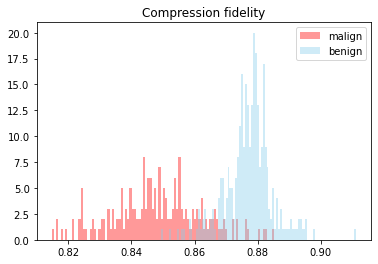

In [22]:
## remeber data waz reverted 

plt.hist(benign_flist, bins = 100 ,label="malign", color = "red",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [23]:
split=0.868


print("split:",split)
b_e=[]
for i in benign_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.868
benign classification accuracy: 0.9230769230769231
malign classification accuracy: 0.9016393442622951
total accuracy: 0.91


## Real hardware 

In [24]:
"""
device_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-11"

# Note: please change the s3 directory accordingly based on your account if you want to run the code
my_bucket = f"amazon-braket-e2ddc0be70c2" # the name of the bucket
my_prefix = "e5results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)
dev_rigetti_aws = qml.device('braket.aws.qubit', device_arn=device_rigetti, shots=2500*2, wires=qubits, s3_destination_folder=s3_folder)

"""

'\ndevice_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-11"\n\n# Note: please change the s3 directory accordingly based on your account if you want to run the code\nmy_bucket = f"amazon-braket-e2ddc0be70c2" # the name of the bucket\nmy_prefix = "e5results" # the name of the folder in the bucket\ns3_folder = (my_bucket, my_prefix)\ndev_rigetti_aws = qml.device(\'braket.aws.qubit\', device_arn=device_rigetti, shots=2500*2, wires=qubits, s3_destination_folder=s3_folder)\n\n'

In [30]:
"""
dev_qiskit = qml.device('qiskit.aer', wires=qubits, backend = 'qasm_simulator')
"""
token = 'bdfb136f41f48dcab8cfc1bad4d78a53ef82fc659bd63e6decfb01526e7897904f5726e4cb3014f34fbb40ab745b733b9fe6219a6d9c28a2ee45cf36da171abb'
IBMQ.save_account(token,overwrite=True)  #save your creds
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon', project='16-qubit')
dev_qiskit = qml.device('qiskit.ibmq', wires=qubits, backend='ibmq_guadalupe',provider=provider)

ibmqfactory.load_account:WARNING:2022-02-25 10:22:28,846: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
@qml.qnode(dev_qiskit)
def training_circuit_real(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])

    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

In [32]:
def fidelity_real(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_real(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [37]:
## Run on benign data:
benign_flist=[]
for i in range(len(benign_data)):
    b=benign_data[i]
    f=fidelity_real(encoder_params, [b])
    np.savetxt('real_IBM/Testing_benign_e5_sample' + str(i) + '.txt', [f])
    benign_flist.append(f.item())
    
print(min(benign_flist))
print(max(benign_flist))

0.4375
0.609375


In [38]:
len(benign_flist)

195

In [45]:
## Run on malign data:
#malign_flist=[]
for i in  range (99,len(malign_data)):
    b=malign_data[i]
    
    f=fidelity_real(encoder_params, [b])
    np.savetxt('real_IBM/Testing_malign_e5_sample' + str(i) + '.txt', [f])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.3837890625
0.6220703125


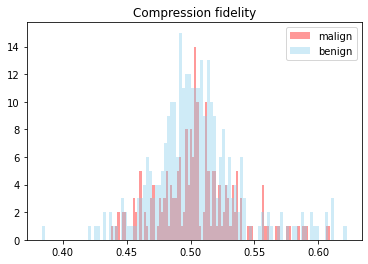

In [43]:
## remeber data waz reverted 

plt.hist(benign_flist, bins = 100 ,label="malign", color = "red",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [44]:
split=0.868


print("split:",split)
b_e=[]
for i in benign_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.868
benign classification accuracy: 1.0
malign classification accuracy: 0.0
total accuracy: 0.39
